# Surface tension calculations using DFT for Hydrogen
Comparing Feynman-Hibbs corrections to first and second order

In [17]:
from feos import *
from feos.si import *
from feos.dft import *
from feos.saftvrqmie import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json

sns.set_context('talk')
sns.set_palette('Dark2')
sns.set_style('ticks')

# Pure fluid surface tension correlations

In [18]:
def surftens_mulero2012(fluid, tr):
    """
    Calculate pure fluid surface tension using Mulero 2012 correlation (doi:10.1063/1.4768782)
    Args:
        fluid (str): Component name
        tr (np.ndarray): Reduced temperature
    Returns:
        sigma (np.ndarray): Surface tension (mN/m)
    """
    ff = open("mulero_2012_parameters.json", "r")
    complist = json.load(ff)
    ff.close()
    sigma = np.zeros_like(tr)
    for i in range(len(complist[fluid]["sigma"])):
        sigma[:] += complist[fluid]["sigma"][i] * \
            (1-tr[:])**complist[fluid]["n"][i]
    return sigma * NEWTON / METER / (MILLI * NEWTON/  METER)

# Hydrogen parameters and functional

In [19]:
# Critical and normal boiling point temperature
Tc = 33.145
Tnb = 20.369
# First order Feynman-Hibbs corrections
parameters_fh1 = SaftVRQMieParameters.from_json(["hydrogen"], "../../parameters/saftvrqmie/aasen2019.json")
func_fh1 = HelmholtzEnergyFunctional.saftvrqmie(parameters_fh1)
state_fh1 = State(func_fh1, temperature=Tnb * KELVIN, pressure=20.0 * BAR)
model_fh1_tc = State.critical_point(func_fh1).temperature
# Second order Feynman-Hibbs corrections
parameters_fh2 = SaftVRQMieParameters.from_json(["hydrogen"], "../../parameters/saftvrqmie/aasen2019_fh2.json")
func_fh2 = HelmholtzEnergyFunctional.saftvrqmie(parameters_fh2)
state_fh2 = State(func_fh2, temperature=Tnb * KELVIN, pressure=20.0 * BAR)
model_fh2_tc = State.critical_point(func_fh2).temperature

# Calculate and plot surface tension

In [20]:
# First order Feynman-Hibbs corrections
dia_fh1 = PhaseDiagram.pure(func_fh1, Tnb * KELVIN, npoints=50)
sft_dia_fh1 = SurfaceTensionDiagram(dia_fh1.states, n_grid=1024, l_grid=200 * ANGSTROM , critical_temperature=model_fh1_tc)
surf_tens_fh1 = sft_dia_fh1.surface_tension / (MILLI* NEWTON / METER)
# Second order Feynman-Hibbs corrections
dia_fh2 = PhaseDiagram.pure(func_fh2, Tnb * KELVIN, npoints=50)
sft_dia_fh2 = SurfaceTensionDiagram(dia_fh2.states, n_grid=1024, l_grid=200 * ANGSTROM , critical_temperature=model_fh2_tc)
surf_tens_fh2 = sft_dia_fh2.surface_tension / (MILLI* NEWTON / METER)

In [21]:
tr = np.linspace(Tnb/Tc, 1.0, 100)
s_corr = surftens_mulero2012("hydrogen", tr)

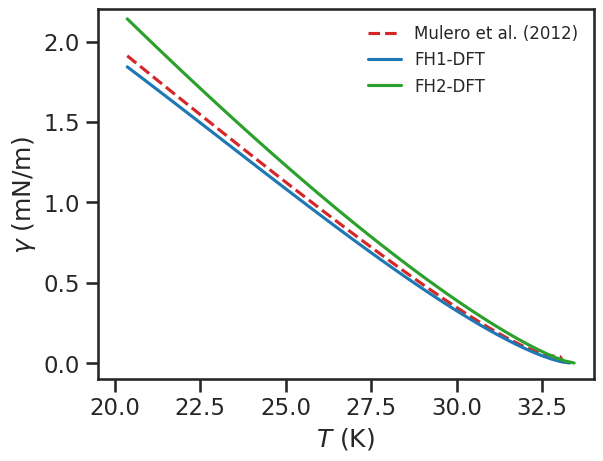

In [22]:
fig, ax = plt.subplots(1, 1)
ax.plot(tr * Tc, s_corr, color='tab:red', label="Mulero et al. (2012)", ls="--")
ax.plot(dia_fh1.liquid.temperature/KELVIN, surf_tens_fh1, color='tab:blue', label='FH1-DFT')
ax.plot(dia_fh2.liquid.temperature/KELVIN, surf_tens_fh2, color='tab:green', label='FH2-DFT')
ax.set_xlim([19.5, 34.0])
ax.set_ylim([-0.1, 2.2])
ax.set_xlabel(r'$T$ (K)')
ax.set_ylabel(r'$\gamma$ (mN/m)')
legend = ax.legend(loc='best', frameon=False, fontsize=12, ncol=1)